In [1]:
import torch
from torch import nn

rnn = nn.LSTM(32, 20, 2)
input = torch.randn(5, 3, 32)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [2]:
%cd

/home/kacper


In [3]:
from DeepLearning.Project2.data_loading_preparation import load_audio_dataloaders_validation

In [4]:
train, test, val = load_audio_dataloaders_validation(bs=128, limit_11=0.0)

In [33]:
def eval_accuracy(model, dataloader, reccurrent, training_device='cpu'):
    with torch.no_grad():
        model.to(training_device)
        correct = 0
        all_so_far = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs.float().to(training_device), labels.float().to(training_device)
            inputs = torch.nn.functional.normalize(inputs)
            if reccurrent is not None:
                yhat = model(inputs, reccurrent)
                pred = torch.argmax(yhat[0][:, -1, :], dim=1)
            else:
                inputs = torch.flatten(inputs, 1)
                yhat = model(inputs)
                pred = torch.argmax(yhat, dim=1)
            
            all_so_far += labels.size().numel()
            correct += torch.sum(pred.eq(labels)).item()
    return correct/all_so_far

In [22]:
device = "cuda"
hidden_layers_count = 1
criterion_weights = torch.tensor([1.] * 11 + [0.0]).to(device)
model = nn.LSTM(32, 12, hidden_layers_count).to(device)

criterion = nn.CrossEntropyLoss(weight=criterion_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

hn_prev = torch.randn(hidden_layers_count, 20, 12).to(device)
cn_prev = torch.randn(hidden_layers_count, 20, 12).to(device)

for epoch in range(1, 251):
    for x, y in train:
        optimizer.zero_grad()
        x, y = x.float().to(device), y.float().to(device)
        x = torch.nn.functional.normalize(x)
        yhat, (hn, cn) = model(x, (hn_prev, cn_prev))
        (hn_prev, cn_prev) = (hn.detach(), cn.detach())
        loss = criterion(yhat[:, -1, :].softmax(1), y.long())
        loss.backward()
        optimizer.step()
    print("loss", loss.item())
    print("acc (val):", eval_accuracy(model, val, (hn, cn), "cuda"))

loss 2.477055072784424
acc (val): 0.10155038759689923
loss 2.475510597229004
acc (val): 0.10426356589147287
loss 2.4745476245880127
acc (val): 0.1003875968992248
loss 2.4742109775543213
acc (val): 0.09922480620155039
loss 2.4740593433380127
acc (val): 0.0996124031007752
loss 2.473973274230957
acc (val): 0.09806201550387597
loss 2.47391676902771
acc (val): 0.09496124031007752
loss 2.473876953125
acc (val): 0.09806201550387597
loss 2.473846673965454
acc (val): 0.09457364341085271
loss 2.4738218784332275
acc (val): 0.09573643410852713
loss 2.4738006591796875
acc (val): 0.09651162790697675
loss 2.4737818241119385
acc (val): 0.09612403100775194
loss 2.473764419555664
acc (val): 0.09651162790697675
loss 2.4737465381622314
acc (val): 0.09689922480620156
loss 2.4737279415130615
acc (val): 0.09689922480620156


KeyboardInterrupt: 

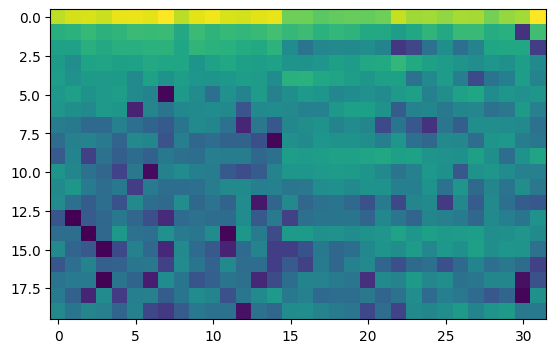

In [18]:
import matplotlib.pyplot as plt
plt.imshow(x[3].cpu())

In [53]:
device = "cuda"
hidden_layers_count = 2
features = 20
layer_size = 12

criterion_weights = torch.tensor([1.] * 11 + [0.0]).to(device)
model = nn.RNN(32, layer_size, hidden_layers_count).to(device)

criterion = nn.CrossEntropyLoss(weight=criterion_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=[0.9, 0.999], eps=10e-8)

hn_prev = torch.randn(hidden_layers_count, features, layer_size).to(device)

for epoch in range(1, 251):
    for x, y in train:
        optimizer.zero_grad()
        x, y = x.float().to(device), y.float().to(device)
        x = torch.nn.functional.normalize(x)
        yhat, hn = model(x, hn_prev)
        (hn_prev) = (hn.detach())
        loss = criterion(yhat[:, -1, :], y.long())
        loss.backward()
        optimizer.step()
    print("loss", loss.item())
    print("acc (val):", eval_accuracy(model, val, hn, "cuda"))

loss 2.3868815898895264
acc (val): 0.10310077519379846


KeyboardInterrupt: 

In [54]:
yhat.shape

torch.Size([128, 20, 12])

In [34]:
device = "cuda"
hidden_layers_count = 1
features = 20
layer_size = 12

criterion_weights = torch.tensor([1.] * 11 + [0.0]).to(device)
model = nn.Sequential(
    nn.Linear(20*32, 4096),
    nn.ReLU(True),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Linear(4096, layer_size),
).to(device)

criterion = nn.CrossEntropyLoss(weight=criterion_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

hn_prev = torch.randn(hidden_layers_count, features, layer_size).to(device)

for epoch in range(1, 251):
    for x, y in train:
        optimizer.zero_grad()
        x, y = x.float().to(device), y.float().to(device)
        x = torch.nn.functional.normalize(x)
        x = torch.flatten(x, 1)
        yhat= model(x)
        loss = criterion(yhat.softmax(1), y.long())
        loss.backward()
        optimizer.step()
    print("loss", loss.item())
    print("acc (val):", eval_accuracy(model, val, None, "cuda"))

loss 2.4166617393493652
acc (val): 0.15271317829457365
loss 2.459350109100342
acc (val): 0.17751937984496124
loss 2.392336368560791
acc (val): 0.17906976744186046
loss 2.4019739627838135
acc (val): 0.1868217054263566
loss 2.4369428157806396
acc (val): 0.18488372093023256
loss 2.3779776096343994
acc (val): 0.19689922480620156
loss 2.365314483642578
acc (val): 0.22906976744186047
loss 2.3339521884918213
acc (val): 0.21511627906976744
loss 2.3218235969543457
acc (val): 0.24457364341085272
loss 2.3631622791290283
acc (val): 0.20852713178294574
loss 2.278571128845215
acc (val): 0.26046511627906976
loss 2.255392551422119
acc (val): 0.2693798449612403
loss 2.324573278427124
acc (val): 0.28449612403100777
loss 2.2738447189331055
acc (val): 0.26046511627906976
loss 2.284839391708374
acc (val): 0.262015503875969
loss 2.2935304641723633
acc (val): 0.2589147286821705
loss 2.243104934692383
acc (val): 0.29496124031007753
loss 2.242361545562744
acc (val): 0.2875968992248062
loss 2.2243733406066895
a

KeyboardInterrupt: 